# Francesca Pecorari SM3201259

# Challenge 1: The banknote-authentication data set problem

We will perform a nearly realistic analysis of the data set bank note authentication that can be downloaded from https://archive.ics.uci.edu/dataset/267/banknote+authentication


## Data set description

Data were extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool were used to extract features from images.
These features are:
1. variance of Wavelet Transformed image (continuous)
2. skewness of Wavelet Transformed image (continuous)
3. curtosis of Wavelet Transformed image (continuous)
4. entropy of image (continuous)
5. class (integer)

## Task description
We have a binary classification problem. The assignment can be divided in several parts:
    
    1. Load the data and pretreatment.
    2. Data exploring by Unsupervised Learning techniques.
    3. Construction of several models of Supervised Learning.

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

### 1. Data pretreatment

Load the data and look at it: It is needed some kind of scaling? Why? Are the data points sorted in the original data set? Can it generate problems? How can this be solved?

In [121]:
FFILE = './banknote+authentication.zip'
if os.path.isfile(FFILE):
    print("File already exists")
    if os.access(FFILE, os.R_OK):
        print ("File is readable")
    else:
        print ("File is not readable, removing it and downloading again")
        !rm FFILE
        !wget "https://archive.ics.uci.edu/static/public/267/banknote+authentication.zip"
else:
    print("Either the file is missing or not readable, download it")
    !wget "https://archive.ics.uci.edu/static/public/267/banknote+authentication.zip"

File already exists
File is readable


In [122]:
# Dataset loading

columns = ['Variance', 'Skewness', 'Curtosis', 'Entropy', 'Class']

# Load the dataset using Pandas
data = pd.read_csv('./banknote+authentication.zip', header = None, names = columns)


# Display the first few rows and the data types of each column
df_head = data.head()
df_dtypes = data.dtypes
print(df_head)
print(df_dtypes)

   Variance  Skewness  Curtosis  Entropy  Class
0   3.62160    8.6661   -2.8073 -0.44699      0
1   4.54590    8.1674   -2.4586 -1.46210      0
2   3.86600   -2.6383    1.9242  0.10645      0
3   3.45660    9.5228   -4.0112 -3.59440      0
4   0.32924   -4.4552    4.5718 -0.98880      0
Variance    float64
Skewness    float64
Curtosis    float64
Entropy     float64
Class         int64
dtype: object


First we check if there are any missing values in the dataset, then we decide to scale the dataset beacuse of the algorithms we are later going to use to analyze it, which require scalling.
The data points are sorted by category.

In [123]:
# Check for missing values in the dataset
df_missing_values = data.isnull().sum()
print(df_missing_values)

Variance    0
Skewness    0
Curtosis    0
Entropy     0
Class       0
dtype: int64


There are no missing values in the dataset.



In [124]:
# Scalinig the data

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the data
scaled_data = scaler.fit_transform(data.drop('Class', axis=1))

# Create a new DataFrame with the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=data.columns[:-1])

# Display the first few rows of the scaled DataFrame
scaled_df_head = scaled_df.head()
print(scaled_df_head)

   Variance  Skewness  Curtosis   Entropy
0  1.121806  1.149455 -0.975970  0.354561
1  1.447066  1.064453 -0.895036 -0.128767
2  1.207810 -0.777352  0.122218  0.618073
3  1.063742  1.295478 -1.255397 -1.144029
4 -0.036772 -1.087038  0.736730  0.096587


In [125]:
# View the summary statistics
summary_stats = data.describe().iloc[:, :-1]
print(summary_stats)


          Variance     Skewness     Curtosis      Entropy
count  1372.000000  1372.000000  1372.000000  1372.000000
mean      0.433735     1.922353     1.397627    -1.191657
std       2.842763     5.869047     4.310030     2.101013
min      -7.042100   -13.773100    -5.286100    -8.548200
25%      -1.773000    -1.708200    -1.574975    -2.413450
50%       0.496180     2.319650     0.616630    -0.586650
75%       2.821475     6.814625     3.179250     0.394810
max       6.824800    12.951600    17.927400     2.449500


### 2. Unsupervised Learning

Use PCA and plot the two first components colouring according with the class. Are the classes linearly separable in this projection? What happens when I applied k-means with two classes in this space? And if I use all the coordinates? Try also t-SNE for projection and DBSCAN for the clustering and comment on the results.

**PCA**

In [126]:
# Calculate the variance-covariance matrix
covariance_matrix = np.cov(data.values.T)

# Print the variance-covariance matrix
print("Variance-Covariance Matrix:")
print(covariance_matrix)


Variance-Covariance Matrix:
[[ 8.08129912e+00  4.40508287e+00 -4.66632326e+00  1.65333797e+00
  -1.02430961e+00]
 [ 4.40508287e+00  3.44457097e+01 -1.99051191e+01 -6.49003300e+00
  -1.29738646e+00]
 [-4.66632326e+00 -1.99051191e+01  1.85763594e+01  2.88724129e+00
   3.33984518e-01]
 [ 1.65333797e+00 -6.49003300e+00  2.88724129e+00  4.41425620e+00
  -2.44641705e-02]
 [-1.02430961e+00 -1.29738646e+00  3.33984518e-01 -2.44641705e-02
   2.47111661e-01]]


In [127]:
# Calculate eigenvectors and eigenvalues of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

# Sort eigenvalues and corresponding eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]  # Reverse the sorted indices to get descending order
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

# Display sorted eigenvalues
print("Sorted Eigenvalues:")
print(sorted_eigenvalues)

# Project the original data onto the principal components
projected_data = np.dot(data.values, sorted_eigenvectors)


Sorted Eigenvalues:
[4.99182748e+01 9.33596699e+00 4.52722782e+00 1.95106291e+00
 3.22035275e-02]


In [128]:
# Calculate the cumulative explained variance ratio
explained_variance_ratio = np.cumsum(sorted_eigenvalues) / np.sum(sorted_eigenvalues)

# Display the cumulative explained variance ratio
print("Cumulative Explained Variance Ratio:")
print(explained_variance_ratio)

# Extract eigenvalues and component indices
eigenvalues_with_indices = [(eig_val, idx) for idx, eig_val in enumerate(sorted_eigenvalues)]

# Display the eigenvalues along with their corresponding component indices
print("Eigenvalues with Component Indices:")
for eig_val, idx in eigenvalues_with_indices:
    print("Component", idx, ": Eigenvalue =", eig_val)

Cumulative Explained Variance Ratio:
[0.75904319 0.90100326 0.96984301 0.99951032 1.        ]
Eigenvalues with Component Indices:
Component 0 : Eigenvalue = 49.918274799290955
Component 1 : Eigenvalue = 9.335966991816047
Component 2 : Eigenvalue = 4.527227816203146
Component 3 : Eigenvalue = 1.9510629089701799
Component 4 : Eigenvalue = 0.032203527499361416


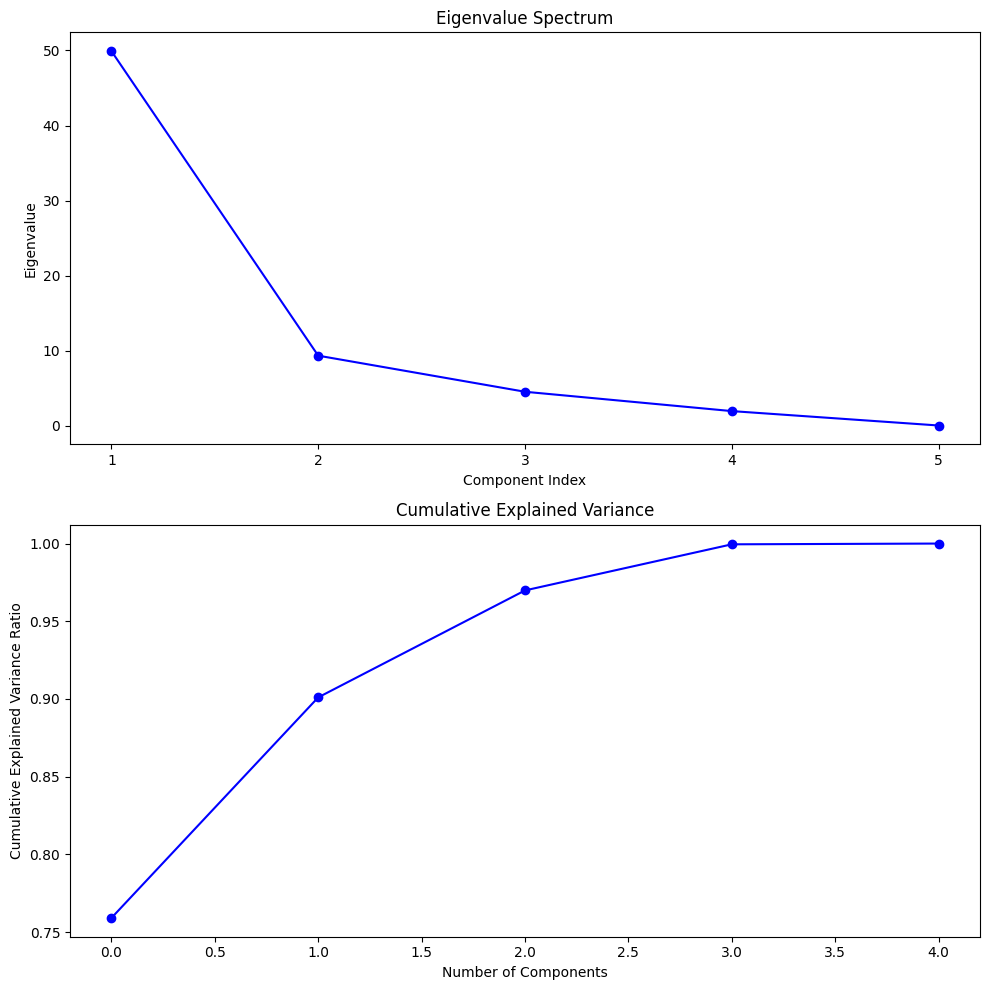

In [129]:
# Creating subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plotting the Spectrum
axs[0].scatter(range(1, len(sorted_eigenvalues) + 1), sorted_eigenvalues, color='blue')
axs[0].plot(range(1, len(sorted_eigenvalues) + 1), sorted_eigenvalues, color='blue', linestyle='-')
axs[0].set_title('Eigenvalue Spectrum')
axs[0].set_xlabel('Component Index')
axs[0].set_ylabel('Eigenvalue')
axs[0].set_xticks(range(1, len(sorted_eigenvalues) + 1))

# Plotting the Cumulative Explained Variance
axs[1].plot(range(len(explained_variance_ratio)), explained_variance_ratio, marker='o', color = 'blue', linestyle='-')
axs[1].set_title('Cumulative Explained Variance')
axs[1].set_xlabel('Number of Components')
axs[1].set_ylabel('Cumulative Explained Variance Ratio')

# Adjusting layout to prevent overlap
plt.tight_layout()

# Displaying the plots
plt.show()


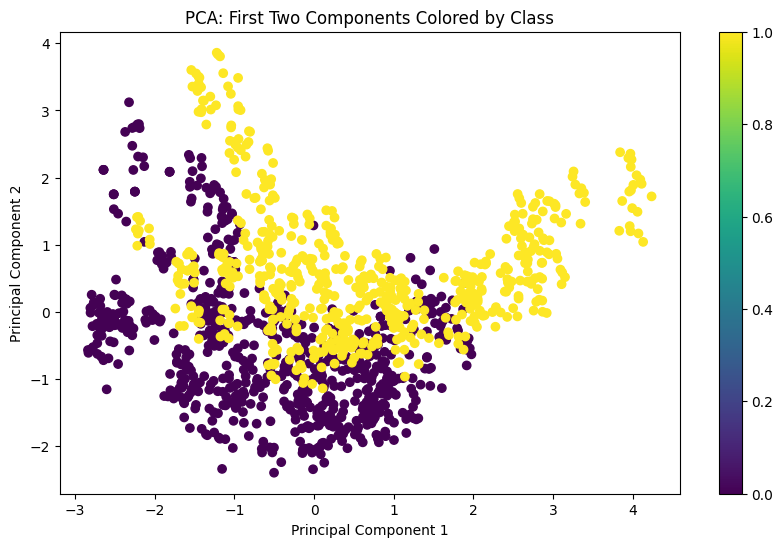

In [130]:
# Apply PCA to the scaled data
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_df)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])

# Add the 'Class' column back to the PCA DataFrame
pca_df['Class'] = data['Class']

# Plot the first two components colored by the 'Class'
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Class'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: First Two Components Colored by Class')
plt.colorbar(scatter)
plt.show()

**KMeans**

In [131]:
# Apply KMeans clustering with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=0)
cluster_labels = kmeans.fit_predict(principal_components)

# Add the cluster labels to the PCA DataFrame
pca_df['Cluster'] = cluster_labels

# Display the first few rows of the PCA DataFrame with cluster labels
pca_df_head = pca_df.head()
print(pca_df_head)

        PC1       PC2  Class  Cluster
0 -1.472805 -1.163917      0        0
1 -1.639441 -1.093812      0        0
2  0.513919 -1.324880      0        1
3 -2.310952 -0.202514      0        0
4  1.193416  0.024654      0        1


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


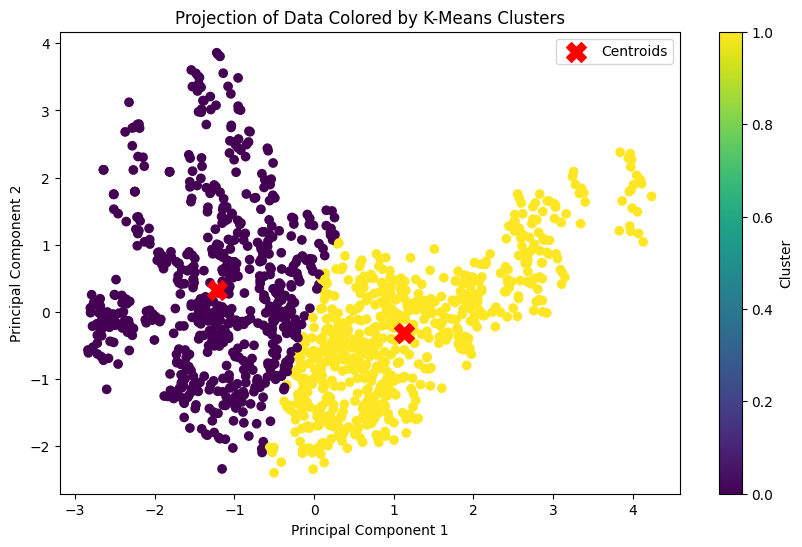

In [132]:
# Obtain the coordinates of the centroids
centroids = kmeans.cluster_centers_

# Plotting the projection according to the k-means clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=cluster_labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='red', label='Centroids')  # Plot centroids
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Projection of Data Colored by K-Means Clusters')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()

In [133]:
# Apply KMeans clustering with 2 clusters using all coordinates
kmeans_all = KMeans(n_clusters=2, random_state=0)
cluster_labels_all = kmeans_all.fit_predict(scaled_df)

# Add the cluster labels to the original DataFrame
data['Cluster'] = cluster_labels_all

# Display the first few rows of the DataFrame with cluster labels
df_head_cluster = data.head()
print(df_head_cluster)

   Variance  Skewness  Curtosis  Entropy  Class  Cluster
0   3.62160    8.6661   -2.8073 -0.44699      0        1
1   4.54590    8.1674   -2.4586 -1.46210      0        1
2   3.86600   -2.6383    1.9242  0.10645      0        0
3   3.45660    9.5228   -4.0112 -3.59440      0        1
4   0.32924   -4.4552    4.5718 -0.98880      0        0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


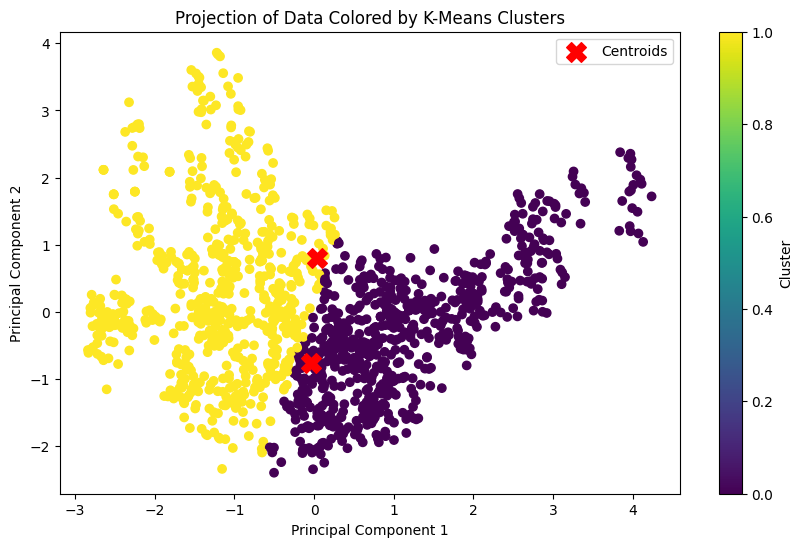

In [134]:
# Obtain the coordinates of the centroids
centroids = kmeans_all.cluster_centers_

# Plotting the projection according to the k-means clusters

plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=cluster_labels_all, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='red', label='Centroids')  # Plot centroids
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Projection of Data Colored by K-Means Clusters')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()

**t-SNE**

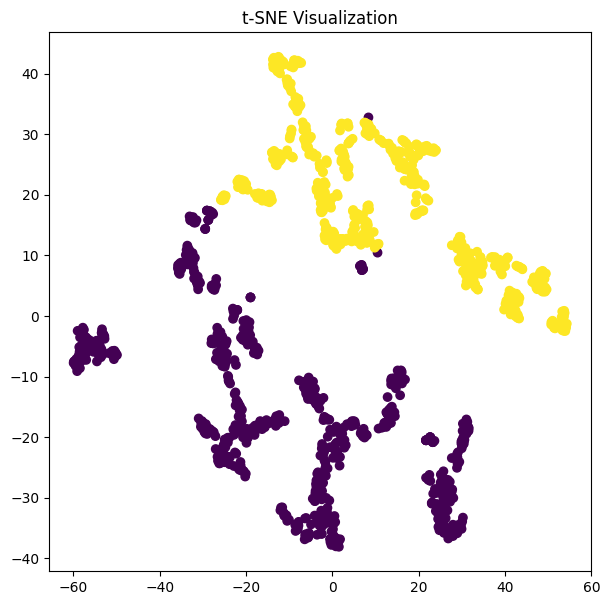

In [135]:
# Apply t-SNE for dimensionality reduction

# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=0)

# Fit and transform the data
tsne_data = tsne.fit_transform(scaled_df)

# Create a DataFrame with the t-SNE results
tsne_df = pd.DataFrame(data=tsne_data, columns=['TSNE1', 'TSNE2'])

# Add the Class and Cluster labels to the t-SNE DataFrame
tsne_df['Class'] = data['Class']
tsne_df['Cluster'] = data['Cluster']

tsne_df_head = tsne_df.head()
tsne_df_head

# Create a scatter plot of the embedded data, colored by ground truth labels
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(tsne_data[:, 0], tsne_data[:, 1], c=data['Class'])

# Set plot title
ax.set_title('t-SNE Visualization')

# Display the plot
plt.show()

**DBSCAN**

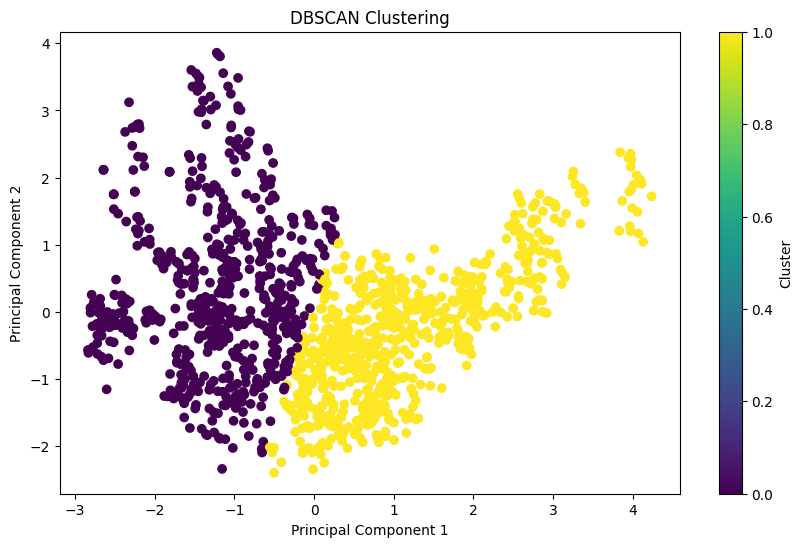

In [136]:
# Initialize DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit DBSCAN to the scaled data
dbscan.fit(scaled_df)

# Obtain the cluster labels
cluster_labels = dbscan.labels_

# Apply PCA to visualize in 2D
principal_components = pca.fit_transform(scaled_df)

# Visualize the clusters using a scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('DBSCAN Clustering')
plt.colorbar(scatter, label='Cluster')
plt.show()

### 3. Supervised Learning

Generate a subset of the data of 372 elements that would be saved as test set. With the rest of the data generate the following models: Logistic Regression, Decision tree (use the ID3 algorithm), Naive Bayesian and k-NN.

Investigate the effect of regularization (when possible) and use cross validation for setting the hyper-parameters when needed.

Compare the performances in terms of accuracy, precision, recall and F1-score on the test set. Comment these results at the light of those obtained from the Unsupervised Learning analysis. Could you propose a way to improve these results?     


**Logistic Regression**

In [137]:
# Split data into features (X) and target variable (y)
X = data.drop(['Class', 'Cluster'], axis=1)
y = data['Class']

# Split data into training and test sets (test_size = 372)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=372, random_state=42)

# Initialize Logistic Regression model
log_reg_model = LogisticRegression()

# Train the model on the training set
log_reg_model.fit(X_train, y_train)

# Predict on the test set
y_test_pred_log = log_reg_model.predict(X_test)

# Calculate accuracy on the test set
accuracy_log = accuracy_score(y_test, y_test_pred_log)

# Calculate precision on the test set
precision_log = precision_score(y_test, y_test_pred_log)

# Calculate recall on the test set
recall_log = recall_score(y_test, y_test_pred_log)

# Calculate F1-score on the test set
f1_log = f1_score(y_test, y_test_pred_log)

print("Accuracy:", accuracy_log)
print("Precision:", precision_log)
print("Recall:", recall_log)
print("F1-score:", f1_log)


Accuracy: 0.9865591397849462
Precision: 0.9817073170731707
Recall: 0.9877300613496932
F1-score: 0.9847094801223242


**Decision Tree**

In [138]:
# Initialize Decision Tree classifier with ID3-like algorithm
dt_classifier = DecisionTreeClassifier(criterion='entropy')  # 'entropy' is similar to ID3's information gain

# Train the Decision Tree classifier
dt_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_dt = dt_classifier.predict(X_test)

# Calculate accuracy on the test set
accuracy_dt = accuracy_score(y_test, y_pred_dt)

# Calculate precision on the test set
precision_dt = precision_score(y_test, y_pred_dt)

# Calculate recall on the test set
recall_dt = recall_score(y_test, y_pred_dt)

# Calculate F1-score on the test set
f1_dt = f1_score(y_test, y_pred_dt)

print("Accuracy:", accuracy_dt)
print("Precision:", precision_dt)
print("Recall:", recall_dt)
print("F1-score:", f1_dt)

Accuracy: 0.9919354838709677
Precision: 1.0
Recall: 0.9815950920245399
F1-score: 0.9907120743034055


**Naive Bayes**

In [139]:
# Initialize Naive Bayes classifier
nb_classifier = GaussianNB()

# Train the classifier
nb_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_nb = nb_classifier.predict(X_test)

# Calculate accuracy on the test set
accuracy_nb = accuracy_score(y_test, y_pred_nb)

# Calculate precision on the test set
precision_nb = precision_score(y_test, y_pred_nb)

# Calculate recall on the test set
recall_nb = recall_score(y_test, y_pred_nb)

# Calculate F1-score on the test set
f1_nb = f1_score(y_test, y_pred_nb)

print("Accuracy:", accuracy_nb)
print("Precision:", precision_nb)
print("Recall:", recall_nb)
print("F1-score:", f1_nb)

Accuracy: 0.8360215053763441
Precision: 0.8642857142857143
Recall: 0.7423312883435583
F1-score: 0.7986798679867987


**Ridge Regression**

In [140]:
# Define the hyperparameters to search
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}  # Regularization strength

# Initialize Logistic Regression model
log_reg_model_l2 = LogisticRegression(penalty='l2')  # L2 regularization (ridge)

# Initialize GridSearchCV
grid_search_l2 = GridSearchCV(log_reg_model_l2, param_grid, cv=5, scoring='accuracy')

# Train the model (find the best C value) on the training set
grid_search_l2.fit(X_train, y_train)

# Get the best regularization parameter found by GridSearchCV
best_C_l2 = grid_search_l2.best_params_['C']

# Initialize Logistic Regression model with the best C value
best_log_reg_model_l2 = LogisticRegression(penalty='l2', C=best_C_l2)

# Train the model on the full training set with the best C value
best_log_reg_model_l2.fit(X_train, y_train)

# Predict on the test set using the best model
y_test_pred_best_l2 = best_log_reg_model_l2.predict(X_test)

# Calculate accuracy on the test set using the best model
test_accuracy_best_l2 = accuracy_score(y_test, y_test_pred_best_l2)

# Calculate precision on the test set using the best model
precision_best_l2 = precision_score(y_test, y_test_pred_best_l2)

# Calculate recall on the test set using the best model
recall_best_l2 = recall_score(y_test, y_test_pred_best_l2)

# Calculate F1-score on the test set using the best model
f1_best_l2 = f1_score(y_test, y_test_pred_best_l2)

# Print the evaluation metrics
print("Accuracy with Best Regularization Parameter (C={}): {:.2f}".format(best_C_l2, test_accuracy_best_l2))
print("Precision with Best Regularization Parameter (C={}): {:.2f}".format(best_C_l2, precision_best_l2))
print("Recall with Best Regularization Parameter (C={}): {:.2f}".format(best_C_l2, recall_best_l2))
print("F1-score with Best Regularization Parameter (C={}): {:.2f}".format(best_C_l2, f1_best_l2))



Accuracy with Best Regularization Parameter (C=1): 0.99
Precision with Best Regularization Parameter (C=1): 0.98
Recall with Best Regularization Parameter (C=1): 0.99
F1-score with Best Regularization Parameter (C=1): 0.98


**Lasso Regression**

In [141]:
# Define the hyperparameters to search
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}  # Regularization strength

# Initialize Logistic Regression model with L1 regularization
log_reg_model_l1 = LogisticRegression(penalty='l1', solver='liblinear')  # L1 regularization (Lasso)

# Initialize GridSearchCV
grid_search_l1 = GridSearchCV(log_reg_model_l1, param_grid, cv=5, scoring='accuracy')

# Train the model (find the best C value) on the training set
grid_search_l1.fit(X_train, y_train)

# Get the best regularization parameter found by GridSearchCV
best_C_l1 = grid_search_l1.best_params_['C']

# Initialize Logistic Regression model with the best C value and L1 regularization
best_log_reg_model_l1 = LogisticRegression(penalty='l1', C=best_C_l1, solver='liblinear')

# Train the model on the full training set with the best C value
best_log_reg_model_l1.fit(X_train, y_train)

# Predict on the test set using the best model
y_test_pred_best_l1 = best_log_reg_model_l1.predict(X_test)

# Calculate accuracy on the test set using the best model
test_accuracy_best_l1 = accuracy_score(y_test, y_test_pred_best_l1)

# Calculate precision on the test set using the best model
precision_best_l1 = precision_score(y_test, y_test_pred_best_l1)

# Calculate recall on the test set using the best model
recall_best_l1 = recall_score(y_test, y_test_pred_best_l1)

# Calculate F1-score on the test set using the best model
f1_best_l1 = f1_score(y_test, y_test_pred_best_l1)

# Print the evaluation metrics
print("Accuracy with Best Regularization Parameter (C={}): {:.2f}".format(best_C_l1, test_accuracy_best_l1))
print("Precision with Best Regularization Parameter (C={}): {:.2f}".format(best_C_l1, precision_best_l1))
print("Recall with Best Regularization Parameter (C={}): {:.2f}".format(best_C_l1, recall_best_l1))
print("F1-score with Best Regularization Parameter (C={}): {:.2f}".format(best_C_l1, f1_best_l1))


Accuracy with Best Regularization Parameter (C=100): 0.99
Precision with Best Regularization Parameter (C=100): 0.99
Recall with Best Regularization Parameter (C=100): 0.99
F1-score with Best Regularization Parameter (C=100): 0.99


**Elastic Nets**

In [142]:
# Define the hyperparameters to search
param_grid_el = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # L1 ratio (0 for L2 penalty only, 1 for L1 penalty only)
}

# Initialize Logistic Regression model with Elastic Net regularization
log_reg_model_el = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000)

# Initialize GridSearchCV
grid_search_el = GridSearchCV(log_reg_model_el, param_grid_el, cv=5, scoring='accuracy')

# Train the model (find the best hyperparameters) on the training set
grid_search_el.fit(X_train, y_train)

# Get the best hyperparameters found by GridSearchCV
best_params_el = grid_search_el.best_params_
best_C_el = best_params_el['C']
best_l1_ratio_el = best_params_el['l1_ratio']

# Initialize Logistic Regression model with the best hyperparameters and Elastic Net regularization
best_log_reg_model_el = LogisticRegression(penalty='elasticnet', C=best_C_el, l1_ratio=best_l1_ratio_el, solver='saga', max_iter=10000)

# Train the model on the full training set with the best hyperparameters
best_log_reg_model_el.fit(X_train, y_train)

# Predict on the test set using the best model
y_test_pred_best_el = best_log_reg_model_el.predict(X_test)

# Calculate accuracy on the test set using the best model
test_accuracy_best_el = accuracy_score(y_test, y_test_pred_best_el)

# Calculate precision on the test set using the best model
precision_best_el = precision_score(y_test, y_test_pred_best_el)

# Calculate recall on the test set using the best model
recall_best_el = recall_score(y_test, y_test_pred_best_el)

# Calculate F1-score on the test set using the best model
f1_best_el = f1_score(y_test, y_test_pred_best_el)

# Print the evaluation metrics

print("Accuracy with Best Regularization Parameters (C={}, l1_ratio={}): {:.2f}".format(best_C_el, best_l1_ratio_el, test_accuracy_best_el))
print("Precision with Best Regularization Parameters (C={}, l1_ratio={}): {:.2f}".format(best_C_el, best_l1_ratio_el, precision_best_el))
print("Recall with Best Regularization Parameters (C={}, l1_ratio={}): {:.2f}".format(best_C_el, best_l1_ratio_el, recall_best_el))
print("F1-score with Best Regularization Parameters (C={}, l1_ratio={}): {:.2f}".format(best_C_el, best_l1_ratio_el, f1_best_el))



Accuracy with Best Regularization Parameters (C=1, l1_ratio=0.1): 0.99
Precision with Best Regularization Parameters (C=1, l1_ratio=0.1): 0.98
Recall with Best Regularization Parameters (C=1, l1_ratio=0.1): 0.99
F1-score with Best Regularization Parameters (C=1, l1_ratio=0.1): 0.98
